# Data Mining and Machine Learning - Team Tissot 
## Ensemble Voting Classifier 
*With TfifdVectorizer and With Word2Vec*


***Detecting the difficulty level of French texts***


# Import the required packages and download the data

To get started, let's import the required packages

In [ ]:
# Import required packages

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import string
sns.set_style("whitegrid")

# Import some additional packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from google.colab import files

In [ ]:
# Download and update spaCy
!pip install -U spacy

# Download and update the french language model
!python -m spacy download fr

# Download and update mlrose (for the ensemble model)
!pip install mlrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⚠ As of spaCy v3.0, shortcuts like 'fr' are deprecated. Please use the
full pipeline package name 'fr_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 536 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=110188cb9f87c0a085ca0a7222844c3cef2ba577d7509c0f2f11c9a5e3390728
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [ ]:
# Import required packages
import spacy
from spacy import displacy

# Load French language model
sp = spacy.load("fr_core_news_sm")

In [ ]:
from nltk.corpus import stopwords        ##This is used to plot the number of stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import gensim
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

Some functions

In [ ]:
def evaluate2(true, pred):
    precision = precision_score(true, pred, average = 'weighted')
    recall = recall_score(true, pred, average = 'weighted')
    f1 = f1_score(true, pred, average = 'weighted')
    acc = accuracy_score(true, pred)
    index = 'result'
    d = {'accuracy': round(acc,4), 'precision': round(precision,4), 'recall': round(recall,4), 'f1 score': round(f1,4) }
    df = pd.DataFrame(d,index=["results"])
    sns.heatmap(pd.DataFrame(confusion_matrix(true, pred)), annot=True, cmap='Oranges', fmt='.7g');
    return df

Then, let's load the data and set "id" as the index column

In [ ]:
# Training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# Unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

Let's have a look on what it looks like:

In [ ]:
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 1. Ensemble models with TfidfVector

### An example of an ensemble model with the TfidfVecotizer. 

> The token for the TfidfVector 
>
>*To clean the data we only lowercase all the words*

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations
    mytokens = sp(sentence)
    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens] 
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Decision Tree Classifier (dtclf)
3.   K-Nearest Neighbors (knnclf)


In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import EnsembleVoteClassifier

In [ ]:
# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=20000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
knnclf = KNeighborsClassifier()

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clf = list of classifiers (logclf, dtclf, knnclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the knnclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, knnclf], weights=[2, 1.5, 1])

In [ ]:
# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f65bcc623a0>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(C=10,
                                                                 max_iter=20000,
                                                                 random_state=0),
                                              DecisionTreeClassifier(criterion='entropy',
                                                                     max_depth=3,
                                                                     random_state=0),
                                              KNeighborsClassifier()],
                                        weights=[2, 1.5, 1]))])

> Evaluate the fitted model

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.45,0.4625,0.45,0.4357


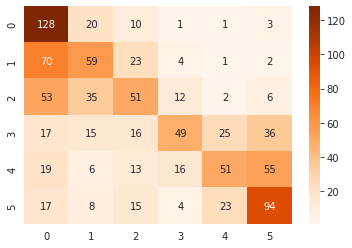

In [ ]:
evaluate2(y_test, y_pred)

> commmenter les résultats

> Submit the model to see the final score.

In [ ]:
predDifficulty = pipe.predict(dfTest['sentence'])
LogPred_DF = pd.DataFrame(data = predDifficulty)
LogPred_DF.index.names = ['id']
LogPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
LogPred_DF.to_csv('Ensemble_tfidf_example')

The score is 0.XXXX .

### The best model found with the TfidfVectorizer

We use the same tokenizer that will lowercase all the word.  

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens ] 
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Multi-layer Perceptron classifier (mlpclf)
3.   Decision Tree Classifier (dtclf)

In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
logclf = LogisticRegression(max_iter=5000, random_state=0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clf = list of classifiers (logclf, mlpclf, rfclf)
* weights = [1.5, 1.5, 1] (1.5 for the Logistic Regression, 2 for the MLP and 1.5 for the Random Forest) 

*The others parameters set with the defaults values.*

In [ ]:
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf], weights=[1.5, 2, 1.5])

In [ ]:
# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f65bb9b48b0>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(max_iter=5000,
                                                                 random_state=0),
                                              MLPClassifier(max_iter=1000,
                                                            random_state=0),
                                              RandomForestClassifier(n_estimators=350,
                                                                     random_state=0)],
                                        weights=[1.5, 2, 1.5]))])

> Evaluate the fitted model

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4812,0.4809,0.4812,0.4736


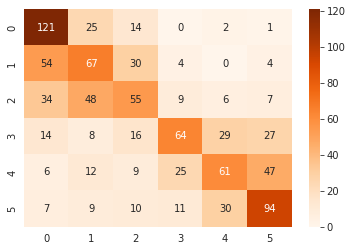

In [ ]:
evaluate2(y_test, y_pred)

> commmenter les résultats

> Submit the model to see the final score.

In [ ]:
predDifficulty = pipe.predict(dfTest['sentence'])
EnsPred_DF = pd.DataFrame(data = predDifficulty)
EnsPred_DF.index.names = ['id']
EnsPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
EnsPred_DF.to_csv('Ensemble_tfidf')

The score is 0.XXXX .

# 2. Ensemble models with Word2Vec

## Set up the base for the model

### Cleaning and tokenizing the sentences

> Cleaning the sentences by removing the stop words and the punctuation, and also lowercase all the words.

In [ ]:
# Set the list of stop words and punctuation
stop_words = spacy.lang.fr.stop_words.STOP_WORDS
punctuations = string.punctuation

In [ ]:
def get_info(df):
 
    text_length = []                          
    number_of_sentences = []
    number_of_words = []
    sent_length_avg = []
    words_length_avg = []
    number_of_words_after_lemma_stop = []
    longest_word_size = []
    
    for text in tqdm(df['sentence'].values):
        
      initial_length = len(text)
      text_length.append(initial_length)
      # Print("sentence_length: %s" % text_length)

      num_sentences = len(sent_tokenize(text))
      number_of_sentences.append(num_sentences)
      # Print("number_of_sentences: %s" % number_of_sentences)

      text2 = text.lower()
      text2 = word_tokenize(text2)
      text2 = [word for word in text2 if word not in punctuations]
      # Print(text2)
      num_words = len(text2)
      number_of_words.append(num_words)
      # Print("number_of_words %s" %number_of_words)

      sent_length_avg.append(num_words/num_sentences)
      # Print("sent_length_avg: %s" %sent_length_avg)

      words_length_avg.append(initial_length/num_words)
      # Print("words_length_avg: %s" %words_length_avg)

      text = sp(text)
      text = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in text]
      text = [word for word in text if not word in spacy.lang.fr.stop_words.STOP_WORDS and word not in punctuations]
      # Print("lemmas +  stopwords: %s" %text)

      num_words_after_lemma_stop = len(text)
      number_of_words_after_lemma_stop.append(num_words_after_lemma_stop)
      # Print("number_of_words_after_lemma_stop: %s" % number_of_words_after_lemma_stop)

      word_len = [len(w) for w in text2]
      longest_word_size.append(np.max(word_len))
      # Print("longest_word_size: %s" % longest_word_size)
        
    final_df = pd.concat([pd.Series(text_length), pd.Series(number_of_sentences),
                             pd.Series(number_of_words), pd.Series(sent_length_avg),
                             pd.Series(words_length_avg), pd.Series(number_of_words_after_lemma_stop),
                             pd.Series(longest_word_size)], axis = 1)
    final_df.columns = ["text_length", "number_of_sentences", "number_of_words",
                           "sent_length_avg", "words_length_avg",
                           "number_of_words_after_lemma_stop", "longest_word_size"]
    
    return final_df

In [ ]:
# Get all the information about the dataset dfTrain.
dfTrainInfo = get_info(dfTrain)

100%|██████████| 4800/4800 [00:36<00:00, 132.50it/s]


> The token to tonekize the sentences
>
>*To clean the data we lowercase and lemmatize all the words*

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ] 
    
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
# Tokenize texts from the dataset dfTrain
processed_texts = []
for text in tqdm(dfTrain["sentence"]):
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

100%|██████████| 4800/4800 [00:33<00:00, 142.68it/s]


In [ ]:
# Tokenize texts from the dataset dfTest
processed_texts_test = []
for text in tqdm(dfTest["sentence"]):
  processed_text_test = spacy_tokenizer(text)
  processed_texts_test.append(processed_text_test)

100%|██████████| 1200/1200 [00:08<00:00, 137.90it/s]


In [ ]:
# After Tokenize both dataset, we join the two processed dataset. 
processed_texts_both = processed_texts + processed_texts_test

### Vectorize with Word2Vec

In [ ]:
#
def hash(astring):
   return ord(astring[0])

In [ ]:
# Word2Vec
model = gensim.models.Word2Vec(size=512, window=50, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)

# Train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=100)

(8323807, 12880800)

In [ ]:
# Note that the result of the each token is divided by the len of the sentence.
vectors = []
for sent in tqdm(processed_texts):
      vectors.append(sum(model[token] for token in sent)/len(sent))

  0%|          | 0/4800 [00:00<?, ?it/s]<ipython-input-38-0b39eb04ec92>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 4800/4800 [00:00<00:00, 9022.37it/s]


In [ ]:
# Create a dataframe with all the vectors
dfVectors = pd.DataFrame(vectors)
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

Slip the processed sentences to train the model and test it. 

In [ ]:
X = dfFinal
y = dfTrain['difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## The Ensemble with Word2Vec 

#### An simple example of an Ensemble with Word2Vec

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Decision Tree Classifier (dtclf)
3.   Linear Support Vector Classifier (svcclf)

In [ ]:
# Import some additional packages 
from sklearn.svm import LinearSVC

# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=15000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
svcclf = LinearSVC(max_iter=2000, tol=0.001, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clf = list of classifiers (logclf, dtclf, svcclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the svcclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, svcclf],weights=[2,1.5,1])

# Train the model
clf_ens.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


EnsembleVoteClassifier(clfs=[LogisticRegression(C=10, max_iter=15000,
                                                random_state=0),
                             DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=3,
                                                    random_state=0),
                             LinearSVC(max_iter=2000, random_state=0,
                                       tol=0.001)],
                       weights=[2, 1.5, 1])

> Evaluate the fitted model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.4823,0.4923,0.4823,0.4761


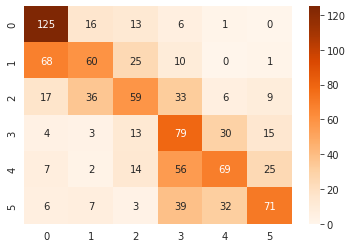

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
evaluate2(y_test, y_pred)

> commmenter les résultats

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

<ipython-input-54-bca4d4cc9e1a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 1200/1200 [00:08<00:00, 137.72it/s]


In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
y_pred_test = clf_ens.predict(dfFinalTest)

SVCPred_DF = pd.DataFrame(data = y_pred_test)
SVCPred_DF.index.names = ['id']
SVCPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
SVCPred_DF.to_csv('Ensemble_w2v_example_1.csv')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

y_pred_test = clf_ens.predict(dfFinalTest)

SVCPred_DF = pd.DataFrame(data = y_pred_test)
SVCPred_DF.index.names = ['id']
SVCPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
SVCPred_DF.to_csv('ensemble_w2v_example_2.csv')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score of the submissions : 


*   Train on the split dfTrain (X_train) : 0.
*   Train on the whole dfTrain : 0.

#### The best model found with an Ensemble and Word2Vec

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Random Forest Classifier (rfclf)
3.   Multi-layer Perceptron classifier (mlpclf)


In [ ]:
# Set up the classifiers with some parameters
logclf = LogisticRegression(max_iter = 20000, C = 10, random_state = 0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clf = list of classifiers (logclf, rfclf, mlpclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the mlpclf, 1 for the rfclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf],weights=[2,1.5,1])

# Train the model
clf_ens.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


EnsembleVoteClassifier(clfs=[LogisticRegression(C=10, max_iter=20000,
                                                random_state=0),
                             MLPClassifier(max_iter=1000, random_state=0),
                             RandomForestClassifier(n_estimators=350,
                                                    random_state=0)],
                       weights=[2, 1.5, 1])

> Evaluate the fitted model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.5219,0.5233,0.5219,0.5194


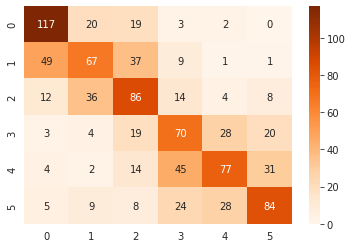

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
evaluate2(y_test, y_pred)

> commmenter les résultats

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

<ipython-input-51-bca4d4cc9e1a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 1200/1200 [00:08<00:00, 134.71it/s]


In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
y_pred_test = clf_ens.predict(dfFinalTest)

SVCPred_DF = pd.DataFrame(data = y_pred_test)
SVCPred_DF.index.names = ['id']
SVCPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
SVCPred_DF.to_csv('Ensemble_w2v_best_1.csv')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

y_pred_test = clf_ens.predict(dfFinalTest)

SVCPred_DF = pd.DataFrame(data = y_pred_test)
SVCPred_DF.index.names = ['id']
SVCPred_DF.rename(columns = {0:'difficulty'}, inplace = True)
SVCPred_DF.to_csv('ensemble_w2v_best_2.csv')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

Score of the submissions : 


*   Train on the split dfTrain (X_train) : 0.
*   Train on the whole dfTrain : 0.